<a href="https://colab.research.google.com/github/OkothOdhi/Skin-disease_classification/blob/main/Skin_disease_detection_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install imagehash

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 69.5 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install torch

In [11]:
!pip install tensorflow

In [9]:
!pip install opencv-python-headless

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 MB 26.8 MB/s eta 0:00:00


In [10]:
from PIL import Image
import os
import cv2
import imagehash
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from collections import Counter
from tqdm import tqdm
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import re
import warnings
warnings.filterwarnings('ignore')
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import hashlib
from PIL import Image, UnidentifiedImageError

In [12]:
folder_path = "/content/drive/MyDrive/Skin-disease_dataset/Cancius_dataset/skin-disease-datasaet/train_set"

In [13]:
def extract_labels_from_filenames(folder_path):
    """Extracts labels from image filenames based on folder structure."""
    labels = {}
    for subdir in os.listdir(folder_path):
        subdir_path = os.path.join(folder_path, subdir)
        if os.path.isdir(subdir_path):
            for filename in os.listdir(subdir_path):
                if filename.lower().endswith((".jpg", ".jpeg", ".png")):
                    # Extract the label from the folder name
                    label = subdir.strip()
                    # Store filename-label pair
                    labels[filename] = label
    return labels

In [15]:
class SkinDiseaseDataset:
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform if transform else transforms.Compose([
            transforms.Resize((224, 224)),  # Resize images
            transforms.ToTensor(),  # Convert images to tensors
            transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize
        ])

        self.image_paths = []
        self.labels = []

        for folder in os.listdir(root_dir):
            folder_path = os.path.join(root_dir, folder)
            if os.path.isdir(folder_path):
                label = folder.replace("-", " ").strip()  # Extract label from folder
                for file in os.listdir(folder_path):
                    if file.endswith((".jpg", ".jpeg", ".png")):
                        self.image_paths.append(os.path.join(folder_path, file))
                        self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [16]:
dataset = SkinDiseaseDataset(folder_path)
print(f"Total samples: {len(dataset)}")

Total samples: 924


In [17]:
# Access a sample
image, label = dataset[300]
print(f"Label: {label}")

Label: BA  cellulitis


In [18]:
def is_well_formatted(img_path):
    """
    Checks if an image is well-formatted (valid, not corrupted, and in RGB mode).

    Returns:
        - True if the image is valid.
        - False if the image is corrupted or misformatted.
    """
    try:
        with Image.open(img_path) as img:
            img.verify()  # Verify if image is not corrupt
            img = Image.open(img_path)  # Reopen to check mode
            img.convert("RGB")  # Ensure it's in RGB format
        return True
    except (UnidentifiedImageError, OSError, ValueError) as e:
        print(f"Misformatted image detected: {img_path} - {e}")
        return False

In [19]:
def check_all_images(root_dir):
    """
    Iterates through all image files in subfolders and checks formatting.

    - root_dir: The main folder containing image subdirectories.
    """
    total_checked = 0
    total_bad = 0

    for folder in os.listdir(root_dir):
        folder_path = os.path.join(root_dir, folder)

        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                if file.endswith((".jpg", ".jpeg", ".png")):
                    img_path = os.path.join(folder_path, file)
                    total_checked += 1

                    if not is_well_formatted(img_path):
                        total_bad += 1  # Count misformatted images

    print(f"Total images checked: {total_checked}")
    print(f"Total misformatted images: {total_bad}")

In [20]:
check_all_images(folder_path)

Total images checked: 924
Total misformatted images: 0


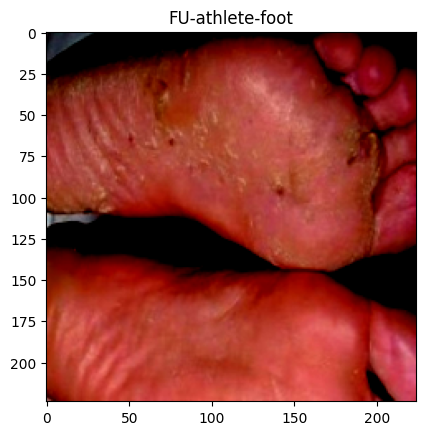

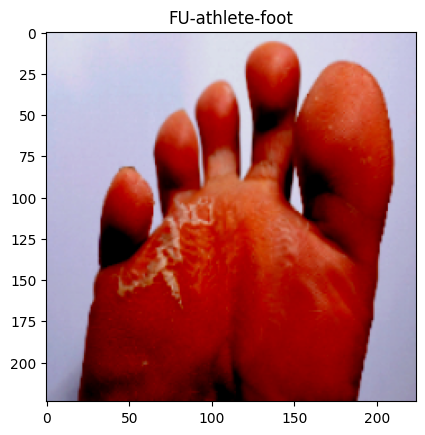

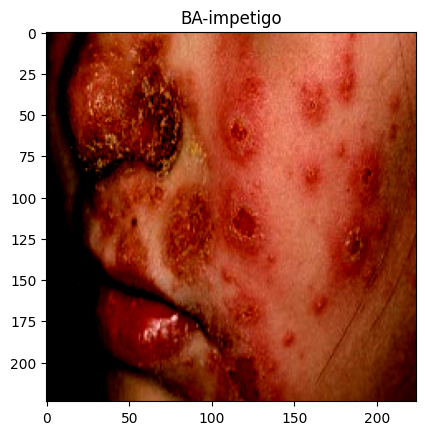

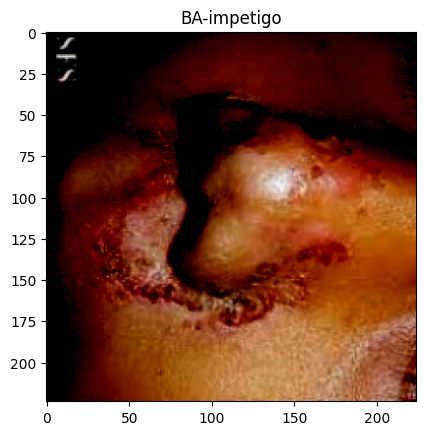

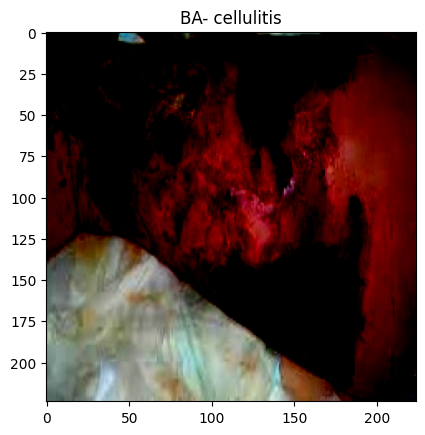

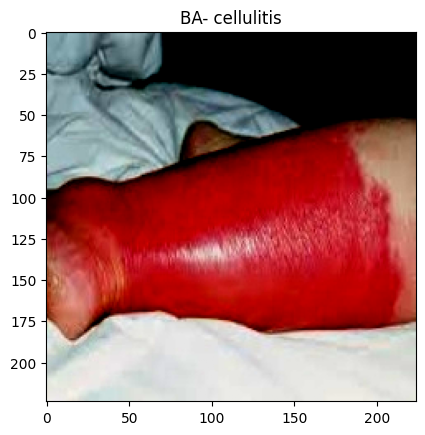

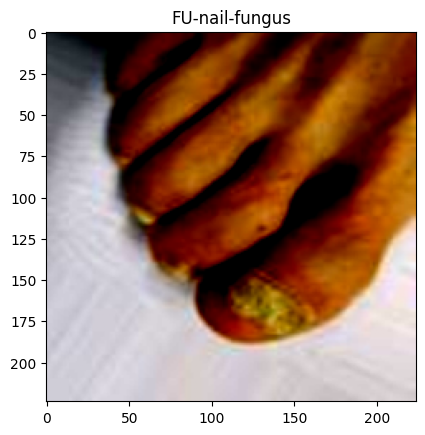

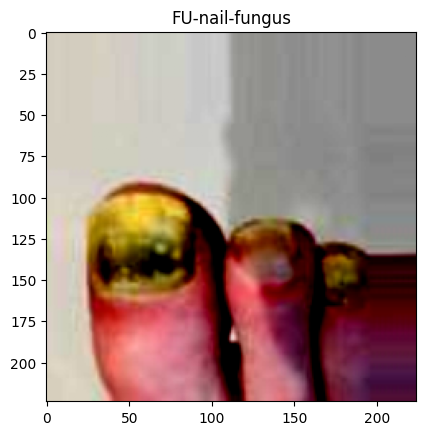

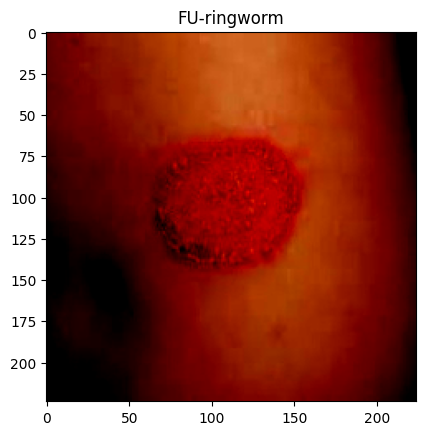

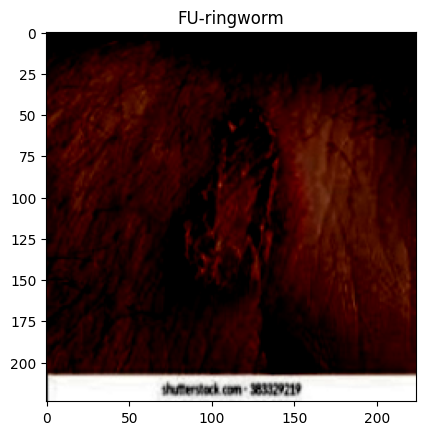

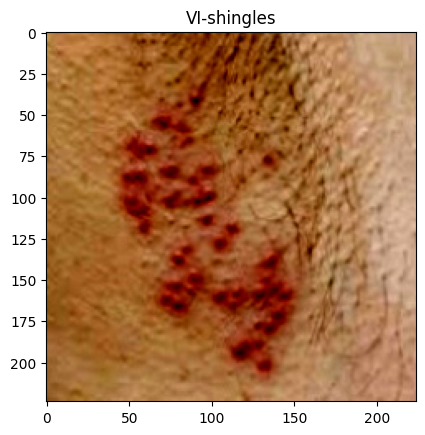

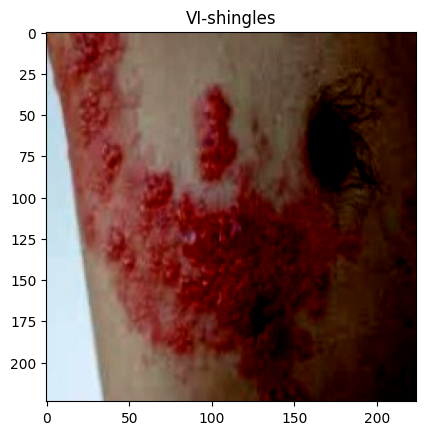

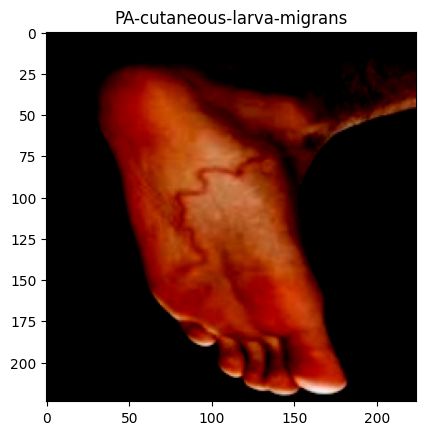

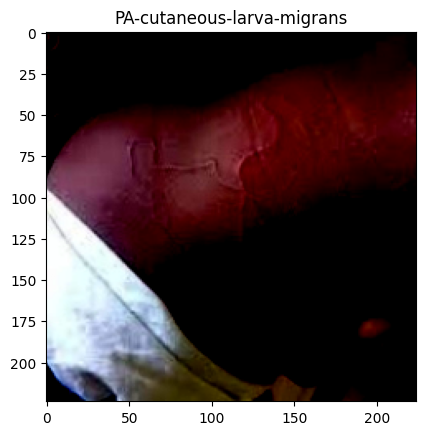

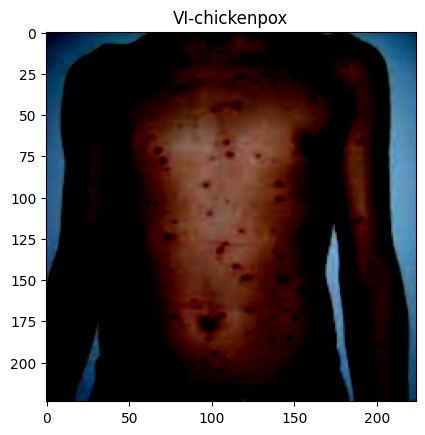

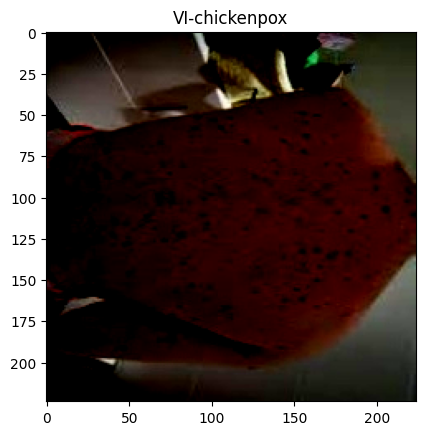

In [21]:
# Iterate through each folder in the dataset's root directory
for folder_name in os.listdir(folder_path):
    folder_path_full = os.path.join(folder_path, folder_name)

    # Check if it's a directory
    if os.path.isdir(folder_path_full):
        # Counter for displayed images in the current folder
        image_count = 0

        # Iterate through files in the folder
        for filename in os.listdir(folder_path_full):
            if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                # Construct the full image path
                image_path = os.path.join(folder_path_full, filename)

                # Open the image using Pillow
                image = Image.open(image_path).convert("RGB")

                # Apply the same transformations as in your dataset
                transform = transforms.Compose([
                    transforms.Resize((224, 224)),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.5], std=[0.5])
                ])
                image = transform(image)

                # Display the image and its label
                plt.imshow(image.permute(1, 2, 0))
                plt.title(folder_name)  # Use folder name as label
                plt.show()

                # Increment the image count
                image_count += 1

                # Break if 2 images have been displayed for this folder
                if image_count >= 2:
                    break

In [22]:
def is_valid_image(img_path):
    """Check if an image file is valid (not corrupt)."""
    try:
        with Image.open(img_path) as img:
            img.verify()  # Verify if the image is valid
        return True
    except (UnidentifiedImageError, OSError):
        print(f"Corrupt image detected: {img_path}")
        return False

In [23]:
def clean_corrupt_images(root_dir, delete_corrupt=False):
    """Iterate through each folder and check for corrupt images."""
    total_images = 0
    corrupt_images = 0

    for folder in os.listdir(root_dir):
        folder_path = os.path.join(root_dir, folder)

        if os.path.isdir(folder_path):  # Ensure it's a folder
            for file in os.listdir(folder_path):
                if file.endswith((".jpg", ".jpeg", ".png")):
                    img_path = os.path.join(folder_path, file)
                    total_images += 1

                    if not is_valid_image(img_path):
                        corrupt_images += 1

                        if delete_corrupt:
                            os.remove(img_path)  # Delete the corrupt image
                            print(f"Deleted corrupt image: {img_path}")

    print(f"Total images checked: {total_images}")
    print(f"Corrupt images found: {corrupt_images}")

In [24]:
clean_corrupt_images(folder_path, delete_corrupt=True)

Total images checked: 924
Corrupt images found: 0


In [25]:
def standardize_images(root_dir, target_size=(224, 224), overwrite=True):
    """
    Standardize images in each folder by resizing and converting to RGB.

    Parameters:
    - root_dir: The root directory containing folders of images.
    - target_size: Tuple (width, height) to resize images.
    - overwrite: If True, replaces the original image. If False, saves as new file.
    """
    total_images = 0
    processed_images = 0

    for folder in os.listdir(root_dir):
        folder_path = os.path.join(root_dir, folder)

        if os.path.isdir(folder_path):  # Ensure it's a folder
            for file in os.listdir(folder_path):
                if file.endswith((".jpg", ".jpeg", ".png")):
                    img_path = os.path.join(folder_path, file)
                    total_images += 1

                    try:
                        with Image.open(img_path) as img:
                            img = img.convert("RGB")  # Convert to RGB (if needed)
                            img = img.resize(target_size, Image.LANCZOS)  # Resize

                            if overwrite:
                                img.save(img_path)  # Replace original
                            else:
                                new_path = os.path.join(folder_path, f"std_{file}")
                                img.save(new_path)  # Save new standardized image

                            processed_images += 1

                    except Exception as e:
                        print(f"Error processing {img_path}: {e}")

    print(f"Total images found: {total_images}")
    print(f"Images successfully standardized: {processed_images}")

In [26]:
standardize_images(folder_path, overwrite=True, target_size=(224, 224))

Total images found: 924
Images successfully standardized: 924


In [27]:
def compute_image_hash(image_path):
    """Generate a hash for an image file to identify duplicates."""
    try:
        with Image.open(image_path) as img:
            img = img.convert("RGB")  # Convert to consistent format
            img_bytes = img.tobytes()  # Get image byte data
            return hashlib.md5(img_bytes).hexdigest()  # Compute MD5 hash
    except Exception as e:
        print(f"Error hashing {image_path}: {e}")
        return None

In [28]:
def remove_duplicate_images(root_dir):
    """
    Removes duplicate images in each folder based on image content.

    - root_dir: The path containing subfolders of images.
    """
    total_removed = 0

    for folder in os.listdir(root_dir):
        folder_path = os.path.join(root_dir, folder)

        if os.path.isdir(folder_path):  # Ensure it's a directory
            hashes = set()  # Set to store unique image hashes

            for filename in os.listdir(folder_path):
                img_path = os.path.join(folder_path, filename)

                if filename.lower().endswith((".jpg", ".jpeg", ".png")):  # Ensure it's an image
                    try:
                        img = Image.open(img_path)
                        img_hash = imagehash.average_hash(img)

                        if img_hash in hashes:
                            total_removed += 1
                            os.remove(img_path)  # Remove duplicate
                            print(f"Removed duplicate: {filename}")
                        else:
                            hashes.add(img_hash)  # Store unique hash
                    except Exception as e:
                        print(f"Skipping unreadable file: {filename}, Error: {e}")

    print(f"Total duplicate images removed: {total_removed}")

In [29]:
remove_duplicate_images(folder_path)

Removed duplicate: FU-athlete-foot (11).jpeg
Removed duplicate: FU-athlete-foot (14).jpeg
Removed duplicate: FU-athlete-foot (15).jpeg
Removed duplicate: FU-athlete-foot (16).jpeg
Removed duplicate: FU-athlete-foot (7).jpeg
Removed duplicate: FU-athlete-foot (6).jpeg
Removed duplicate: FU-athlete-foot (59).jpg
Removed duplicate: FU-athlete-foot (67).jpg
Removed duplicate: FU-athlete-foot (66).jpg
Removed duplicate: FU-athlete-foot (6).png
Removed duplicate: FU-athlete-foot (61).jpg
Removed duplicate: FU-athlete-foot (58).jpg
Removed duplicate: FU-athlete-foot (5).jpg
Removed duplicate: FU-athlete-foot (50).jpg
Removed duplicate: FU-athlete-foot (49).jpg
Removed duplicate: FU-athlete-foot (46).jpg
Removed duplicate: FU-athlete-foot (43).jpg
Removed duplicate: FU-athlete-foot (47).jpg
Removed duplicate: FU-athlete-foot (39).jpg
Removed duplicate: FU-athlete-foot (38).jpg
Removed duplicate: FU-athlete-foot (4).jpeg
Removed duplicate: FU-athlete-foot (5).png
Removed duplicate: FU-athlete-f

In [30]:
clean_corrupt_images(folder_path, delete_corrupt=True)

Total images checked: 676
Corrupt images found: 0


In [31]:
def normalize_and_save_image(img_path, save_path, target_size=(224, 224)):
    """
    Loads, normalizes, and saves an image using TensorFlow.

    - img_path: Path to the original image
    - save_path: Path to save the normalized image
    - target_size: Desired image size (default: 224x224)
    """

    try:
      # Load the image
      img = tf.io.read_file(img_path)
      img = tf.image.decode_jpeg(img, channels=3)

      # Resize to target size
      img = tf.image.resize(img, target_size)

      # Normalize the pixel value to [0, 1]
      img = img / 255.0

      # Converting back to uint8 format (0-255) for saving
      img = tf.image.convert_image_dtype(img, tf.uint8)

      # Save the image
      img_encoded = tf.io.encode_jpeg(img)
      tf.io.write_file(save_path, img_encoded)

      return True
    except Exception as e:
      print(f"Error processing {img_path}: {e}")
      return False

In [32]:
def normalize_images_in_folders(root_dir, output_dir):
    """
    Normalizes all images in subfolders under root_dir and saves them to output_dir.

    - root_dir: Path containing disease folders with images
    - output_dir: Path to save normalized images
    """
    os.makedirs(output_dir, exist_ok=True)  # Create output directory if not exist
    total_normalized = 0

    for folder in os.listdir(root_dir):
        folder_path = os.path.join(root_dir, folder)
        save_folder = os.path.join(output_dir, folder)
        os.makedirs(save_folder, exist_ok=True)  # Create subfolder in output

        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                if file.endswith((".jpg", ".jpeg", ".png")):
                    img_path = os.path.join(folder_path, file)
                    save_path = os.path.join(save_folder, file)

                    if normalize_and_save_image(img_path, save_path):
                        total_normalized += 1

    print(f"Total images normalized: {total_normalized}")

In [38]:
normalize_data = "/content/drive/MyDrive/Skin-disease_dataset/Cancius_dataset/skin-disease-datasaet/augumented_data"
normalize_images_in_folders(folder_path, normalize_data)

Total images normalized: 676


In [41]:
def augment_image(image):
    """
    Applies random augmentations to a given image tensor.

    - Random flip (horizontal & vertical)
    - Random rotation (up to 20 degrees)
    - Random brightness change
    - Random zoom
    """
    # Randomly flip the image
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)

    # Random rotation (up to 20 degrees)
    image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))

    # Random brightness adjustment
    image = tf.image.random_brightness(image, max_delta=0.2)

    # Random zoom by cropping and resizing
    crop_size = tf.random.uniform(shape=[], minval=180, maxval=224, dtype=tf.int32)  # Crop between 180-224 px
    image = tf.image.resize_with_crop_or_pad(image, crop_size, crop_size)
    image = tf.image.resize(image, [224, 224])

    return image

In [40]:
def augment_and_save_images(input_dir, output_dir, augment_count=3):
    """
    Applies augmentation to all images in input_dir and saves them to output_dir.

    - augment_count: Number of augmented copies per image.
    """
    os.makedirs(output_dir, exist_ok=True)
    total_augmented = 0

    for folder in os.listdir(input_dir):
        folder_path = os.path.join(input_dir, folder)
        save_folder = os.path.join(output_dir, folder)
        os.makedirs(save_folder, exist_ok=True)

        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                if file.endswith((".jpg", ".jpeg", ".png")):
                    img_path = os.path.join(folder_path, file)

                    try:
                        # Load image
                        img = tf.io.read_file(img_path)
                        img = tf.image.decode_jpeg(img, channels=3)
                        img = tf.image.resize(img, [224, 224])  # Ensure size

                        # Save original image
                        original_save_path = os.path.join(save_folder, file)
                        img_encoded = tf.io.encode_jpeg(tf.cast(img, tf.uint8))
                        tf.io.write_file(original_save_path, img_encoded)

                        # Apply augmentations
                        for i in range(augment_count):
                            augmented_img = augment_image(img)
                            aug_save_path = os.path.join(save_folder, f"aug_{i}_{file}")
                            img_encoded = tf.io.encode_jpeg(tf.cast(augmented_img, tf.uint8))
                            tf.io.write_file(aug_save_path, img_encoded)
                            total_augmented += 1

                    except Exception as e:
                        print(f"Error processing {img_path}: {e}")

    print(f"Total augmented images created: {total_augmented}")

In [42]:
augumented_folder = "/content/drive/MyDrive/Skin-disease_dataset/Cancius_dataset/skin-disease-datasaet/augumented_data"
augment_and_save_images(normalize_data, augumented_folder)

Total augmented images created: 2028


In [43]:
def generate_image_statistics(dataset_path):
    """Generate and display 7 different image analysis graphs."""
    categories, image_counts = [], []
    widths, heights, avg_intensity, avg_brightness, avg_contrast = [], [], [], [], []

    # Process each folder in the dataset
    for folder in os.listdir(dataset_path):
        folder_path = os.path.join(dataset_path, folder)
        if os.path.isdir(folder_path):
            count = 0
            for file in os.listdir(folder_path):
                if file.endswith((".jpg", ".jpeg", ".png")):
                    img_path = os.path.join(folder_path, file)
                    try:
                        with Image.open(img_path) as img:
                            count += 1
                            widths.append(img.width)
                            heights.append(img.height)

                        # Read with OpenCV for pixel analysis
                        img_cv = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                        if img_cv is not None:
                            avg_intensity.append(np.mean(img_cv))
                            avg_brightness.append(np.mean(img_cv) / 255.0)  # Normalize brightness
                            avg_contrast.append(np.std(img_cv))  # Standard deviation for contrast

                    except Exception as e:
                        print(f"Error processing {img_path}: {e}")

            categories.append(folder)
            image_counts.append(count)

    # Set up subplots
    fig, axes = plt.subplots(3, 3, figsize=(18, 12))
    fig.suptitle("Image Dataset Analysis", fontsize=16)

    # 1. Number of Images Per Category
    axes[0, 0].bar(categories, image_counts, color='skyblue')
    axes[0, 0].set_title("Image Distribution Across Categories")
    axes[0, 0].set_xlabel("Disease Category")
    axes[0, 0].set_ylabel("Number of Images")
    axes[0, 0].tick_params(axis='x', rotation=45)

    # 2. Image Size Distribution
    axes[0, 1].hist(widths, bins=20, alpha=0.5, label="Width", color="blue")
    axes[0, 1].hist(heights, bins=20, alpha=0.5, label="Height", color="red")
    axes[0, 1].set_title("Distribution of Image Sizes")
    axes[0, 1].set_xlabel("Pixels")
    axes[0, 1].set_ylabel("Frequency")
    axes[0, 1].legend()

    # 3. Average Pixel Intensity Distribution
    axes[0, 2].hist(avg_intensity, bins=30, color='green', alpha=0.7)
    axes[0, 2].set_title("Pixel Intensity Distribution")
    axes[0, 2].set_xlabel("Intensity")
    axes[0, 2].set_ylabel("Frequency")

    # 4. Aspect Ratio Distribution
    aspect_ratios = np.array(widths) / np.array(heights)
    axes[1, 0].hist(aspect_ratios, bins=20, color='purple', alpha=0.7)
    axes[1, 0].set_title("Aspect Ratio Distribution")
    axes[1, 0].set_xlabel("Aspect Ratio (Width/Height)")
    axes[1, 0].set_ylabel("Frequency")

    # 5. Brightness Distribution
    axes[1, 1].hist(avg_brightness, bins=30, color='gold', alpha=0.7)
    axes[1, 1].set_title("Brightness Distribution")
    axes[1, 1].set_xlabel("Brightness (0-1)")
    axes[1, 1].set_ylabel("Frequency")

    # 6. Contrast Distribution
    axes[1, 2].hist(avg_contrast, bins=30, color='orange', alpha=0.7)
    axes[1, 2].set_title("Contrast Distribution")
    axes[1, 2].set_xlabel("Contrast (Std Dev)")
    axes[1, 2].set_ylabel("Frequency")

    # 7. Color Distribution (RGB Histogram) for Sample Image
    sample_image = os.path.join(dataset_path, os.listdir(dataset_path)[0], os.listdir(os.path.join(dataset_path, os.listdir(dataset_path)[0]))[0])
    img_sample = cv2.imread(sample_image)
    colors = ('b', 'g', 'r')
    for i, color in enumerate(colors):
        hist = cv2.calcHist([img_sample], [i], None, [256], [0, 256])
        axes[2, 0].plot(hist, color=color)
    axes[2, 0].set_title("RGB Color Distribution")
    axes[2, 0].set_xlabel("Pixel Value")
    axes[2, 0].set_ylabel("Frequency")

    # Hide extra subplots
    axes[2, 1].axis('off')
    axes[2, 2].axis('off')

    # Show all graphs
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


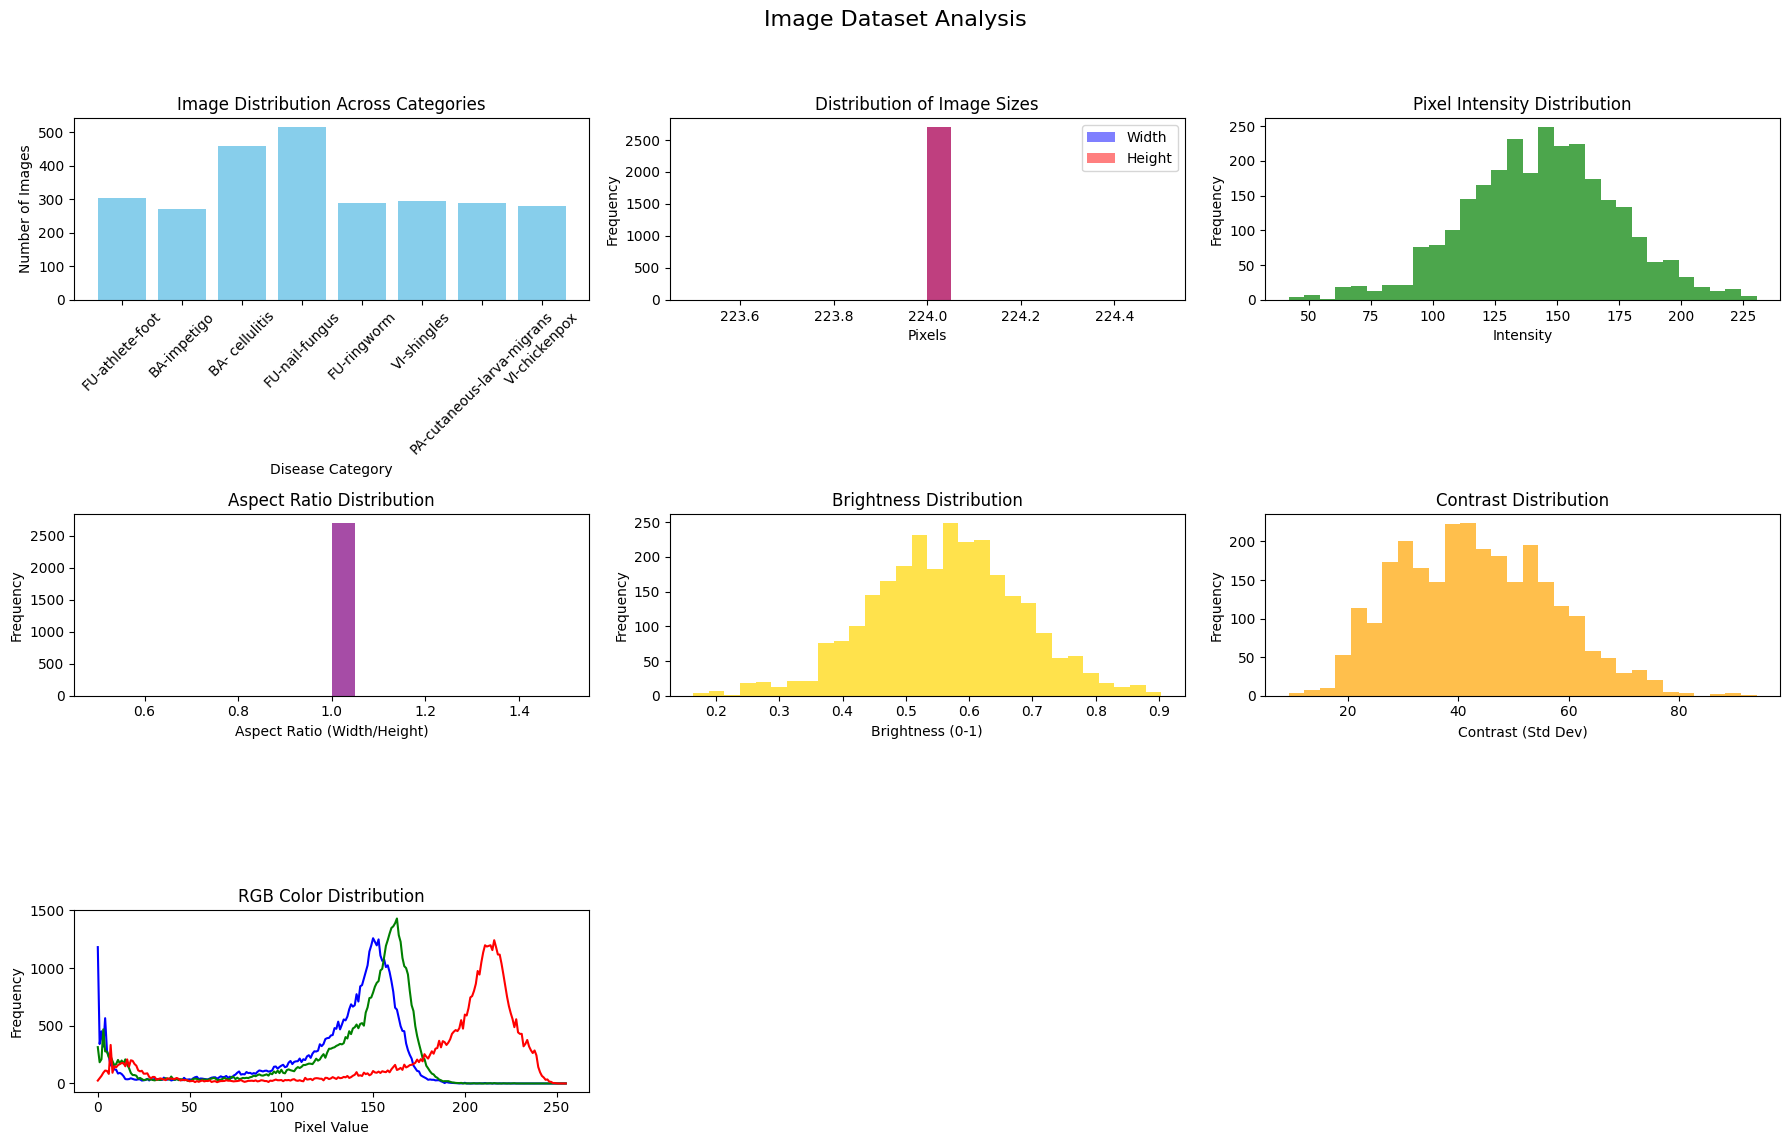

In [45]:
generate_image_statistics(augumented_folder)

In [ ]:
# generate_image_statistics(folder_path)

In [46]:
def plot_class_distribution(folder_path):
  class_count = {}
  for folder in os.listdir(folder_path):
    folder_path_full = os.path.join(folder_path, folder)
    if os.path.isdir(folder_path_full):
      class_count[folder] = len(os.listdir(folder_path_full))

  plt.figure(figsize=(15,15))
  plt.bar(class_count.keys(), class_count.values(), color='skyblue')
  plt.xlabel('Class')
  plt.ylabel('Number of Images')
  plt.title('Class Distribution')
  plt.xticks(rotation=90)
  plt.show()

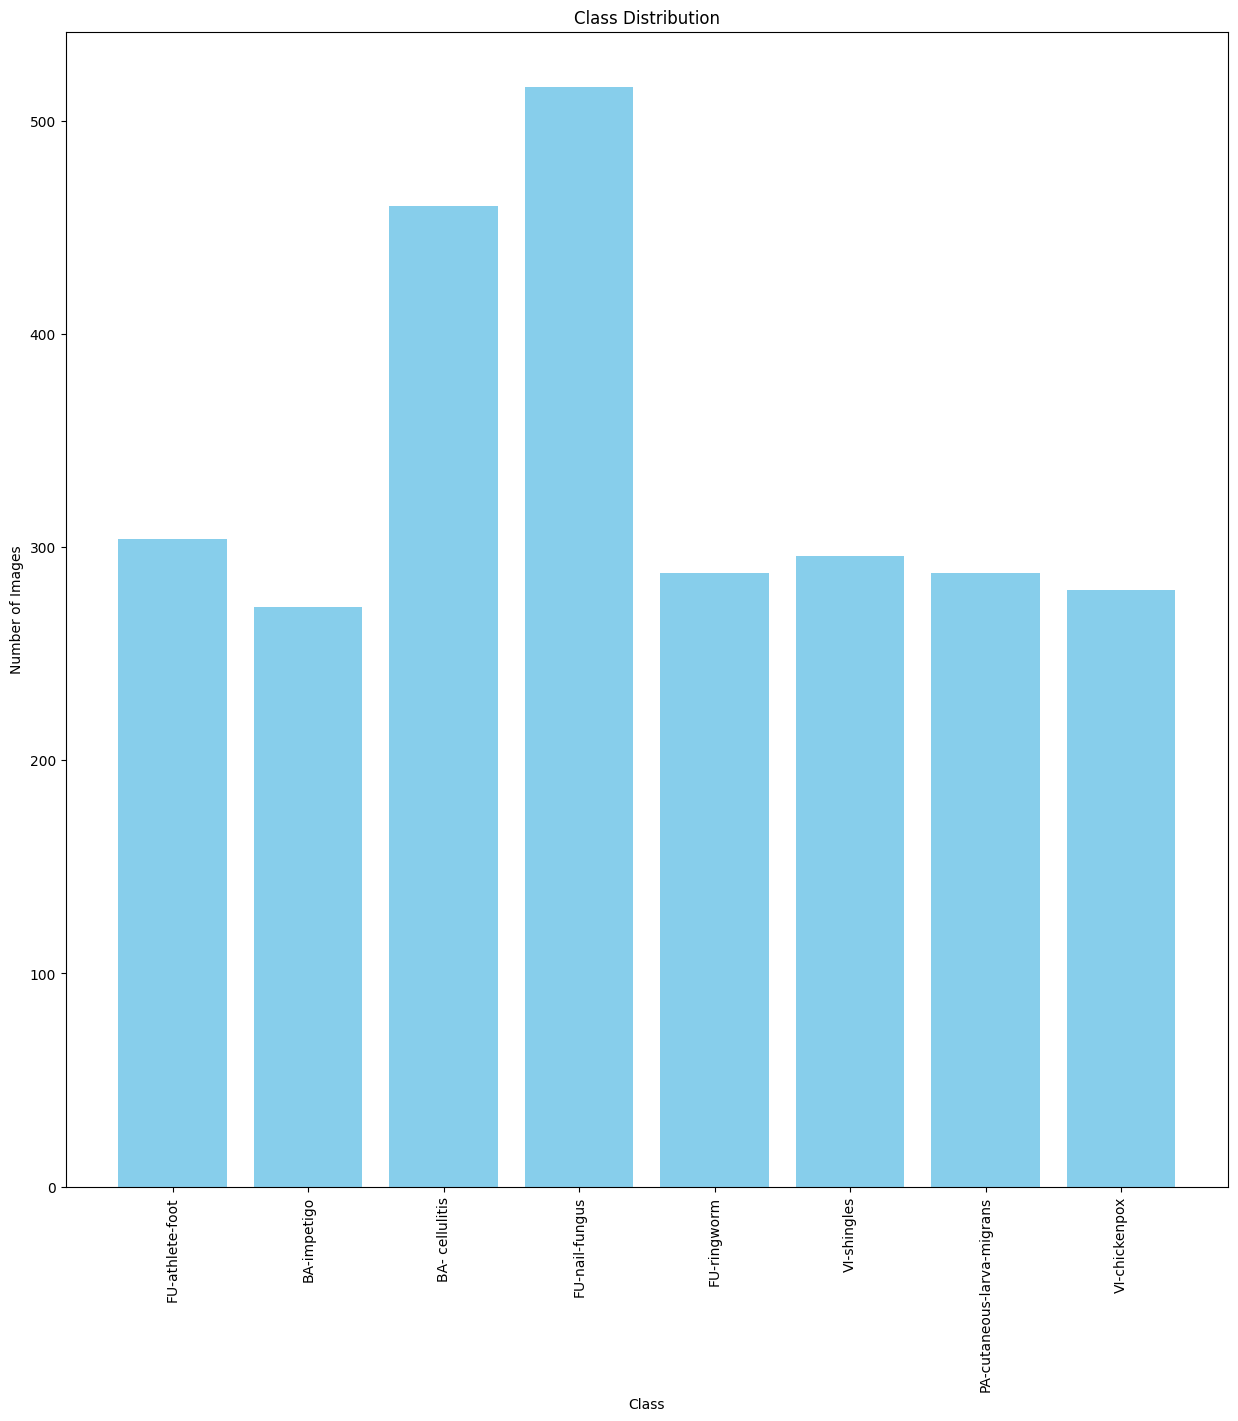

In [47]:
plot_class_distribution(augumented_folder)

In [49]:
def plot_image_size_distribution(root_dir):
    sizes = []
    for class_name in os.listdir(root_dir):
        class_path = os.path.join(root_dir, class_name)
        if os.path.isdir(class_path):
            for file in os.listdir(class_path):
                img_path = os.path.join(class_path, file)
                try:
                    with Image.open(img_path) as img:
                        sizes.append(img.size)
                except:
                    continue

    widths, heights = zip(*sizes)
    plt.figure(figsize=(10, 5))
    plt.scatter(widths, heights, alpha=0.5, color='green')
    plt.xlabel("Width")
    plt.ylabel("Height")
    plt.title("Image Size Distribution")
    plt.show()

Image Explanation

The image generated by this code is a scatter plot showing the distribution of image sizes in your dataset.

X-axis: Represents the width of the images in pixels.
Y-axis: Represents the height of the images in pixels.
Each point: Represents a single image in your dataset. The position of the point indicates its width and height.
Clustering: If you see clusters of points in specific areas of the plot, it indicates that many images have similar dimensions.
Outliers: Points that are far away from the main cluster might represent images with unusual sizes (either very large or very small).
Interpretation

By looking at the scatter plot, you can get a sense of the variability in image sizes within your dataset. This information can be useful for:

Data Preprocessing: Understanding the size distribution helps in making informed decisions about resizing or cropping images during data preparation.
Identifying Outliers: You can easily spot outlier images that might need special attention or removal.
Model Performance: Image size variability can sometimes impact the performance of your model. If there's a very wide range of sizes, it might be helpful to standardize them for better consistency.

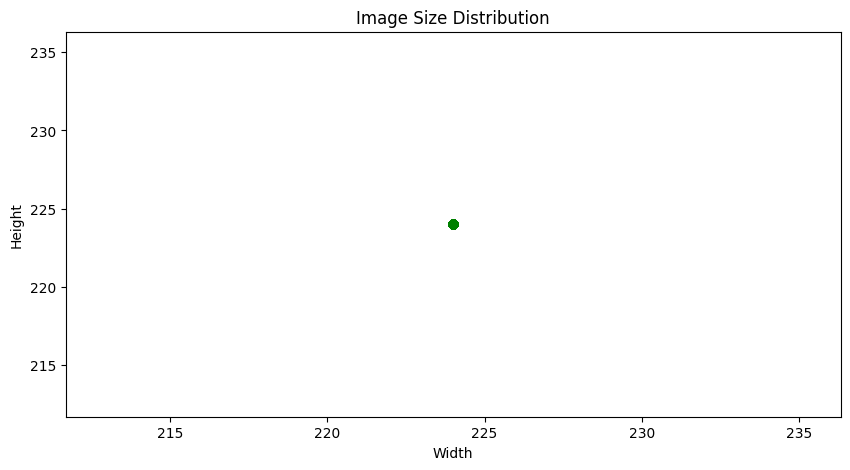

In [50]:
plot_image_size_distribution(augumented_folder)

In [51]:
def plot_aspect_ratio_distribution(root_dir):
    aspect_ratios = []
    for class_name in os.listdir(root_dir):
        class_path = os.path.join(root_dir, class_name)
        if os.path.isdir(class_path):
            for file in os.listdir(class_path):
                img_path = os.path.join(class_path, file)
                try:
                    with Image.open(img_path) as img:
                        aspect_ratios.append(img.size[0] / img.size[1])
                except:
                    continue

    plt.figure(figsize=(10, 5))
    plt.hist(aspect_ratios, bins=20, color='purple', alpha=0.7)
    plt.xlabel("Aspect Ratio (Width / Height)")
    plt.ylabel("Count")
    plt.title("Aspect Ratio Distribution")
    plt.show()

## Image Explanation

The image generated by this code is a histogram that shows the distribution of aspect ratios in your dataset.

X-axis: Represents the aspect ratio (width / height) of the images.
Y-axis: Represents the frequency or count of images with a particular aspect ratio.
Bars: Each bar in the histogram represents a range of aspect ratios, and the height of the bar indicates how many images fall within that range.

## Interpretation

Common Aspect Ratios: The tallest bars in the histogram indicate the most common aspect ratios in your dataset.
Variability: The spread of the histogram shows the variability of aspect ratios. A narrow histogram means most images have similar aspect ratios, while a wide histogram indicates more diversity in image shapes.
Outliers: Bars at the extreme ends of the histogram might represent images with unusual aspect ratios (very wide or very tall).

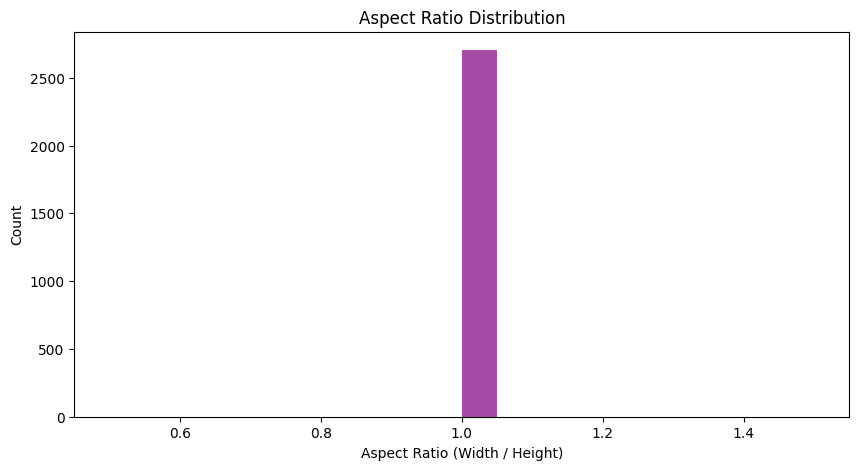

In [52]:
plot_aspect_ratio_distribution(augumented_folder)

In [53]:
def plot_mean_pixel_intensity(root_dir):
    mean_intensities = []
    for class_name in os.listdir(root_dir):
        class_path = os.path.join(root_dir, class_name)
        if os.path.isdir(class_path):
            for file in os.listdir(class_path):
                img_path = os.path.join(class_path, file)
                try:
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    mean_intensities.append(np.mean(img))
                except:
                    continue

    plt.figure(figsize=(10, 5))
    plt.hist(mean_intensities, bins=30, color='orange', alpha=0.7)
    plt.xlabel("Mean Pixel Intensity")
    plt.ylabel("Count")
    plt.title("Mean Pixel Intensity Distribution")
    plt.show()

## Image Explanation

The image generated by this code is a histogram that shows the distribution of mean pixel intensities in your dataset.

X-axis: Represents the mean pixel intensity values. For grayscale images, this typically ranges from 0 (black) to 255 (white).
Y-axis: Represents the frequency or count of images with a particular mean pixel intensity.
Bars: Each bar in the histogram represents a range of mean pixel intensities, and the height of the bar indicates how many images fall within that range.

## Interpretation

Brightness Distribution: The histogram essentially shows the overall brightness distribution of your images.
A peak towards the lower end of the x-axis indicates a higher number of darker images.
A peak towards the higher end suggests more brighter images.
A more evenly distributed histogram indicates a good balance of brightness levels.
Exposure Issues: If the histogram is heavily skewed towards one end (very dark or very bright), it might indicate exposure issues in your dataset.
Data Preprocessing: You can use this information to decide whether you need to apply brightness adjustments or other preprocessing techniques to improve the distribution of pixel intensities.

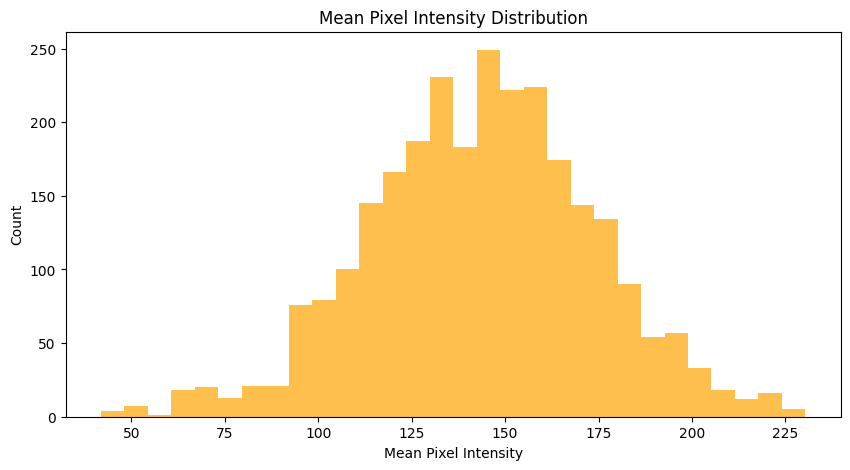

In [54]:
plot_mean_pixel_intensity(augumented_folder)

In [55]:
def plot_color_distribution(root_dir):
  color_channels = {'Red': [], "Green": [], "Blue": []}

  for folder in os.listdir(root_dir):
    folder_path = os.path.join(root_dir, folder)
    if os.path.isdir(folder_path):
      for file in os.listdir(folder_path):
        img_path = os.path.join(folder_path, file)
        try:
          img = cv2.imread(img_path)
          if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            r, g, b = cv2.split(img)
            color_channels['Red'].extend(r.flatten())
            color_channels['Green'].extend(g.flatten())
            color_channels['Blue'].extend(b.flatten())
        except:
          continue

    plt.figure(figsize=(10, 5))
    plt.hist(color_channels["Red"], bins=30, color='red', alpha=0.5, label='Red')
    plt.hist(color_channels["Green"], bins=30, color='green', alpha=0.5, label='Green')
    plt.hist(color_channels["Blue"], bins=30, color='blue', alpha=0.5, label='Blue')
    plt.xlabel("Color Intensity")
    plt.ylabel("Count")
    plt.title("Color Distribution")
    plt.legend()
    plt.show()

## Image Explanation

The image generated by this code is a histogram showing the distribution of color intensities in your dataset, with separate histograms overlaid for the Red, Green, and Blue channels.

X-axis: Represents the color intensity values (typically ranging from 0 to 255).
Y-axis: Represents the frequency or count of pixels with a particular color intensity.
Red, Green, Blue Histograms: Each histogram shows the distribution of pixel intensities for the corresponding color channel. The height of a bar indicates how many pixels have that color intensity value within that channel.

## Interpretation

Color Balance: The histograms show the overall color balance of your images.
If one color channel is dominant, it indicates images might have a color cast or bias.
If the histograms are relatively balanced, it suggests a more even distribution of colors.
Image Content: The shape of the histograms can give you hints about the content of your images. For example, images with a lot of greenery might have a peak in the green channel.
Data Preprocessing: This information can be used to make decisions about color adjustments during preprocessing. For example, if images are consistently too dark, you might adjust the brightness or contrast.
In summary, this color distribution plot provides insights into the color characteristics of your dataset, helping you understand color balance, image content, and potential preprocessing need

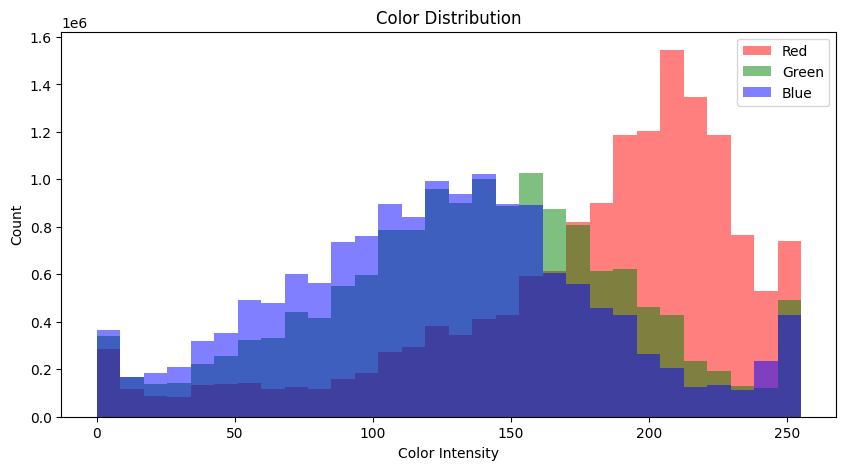

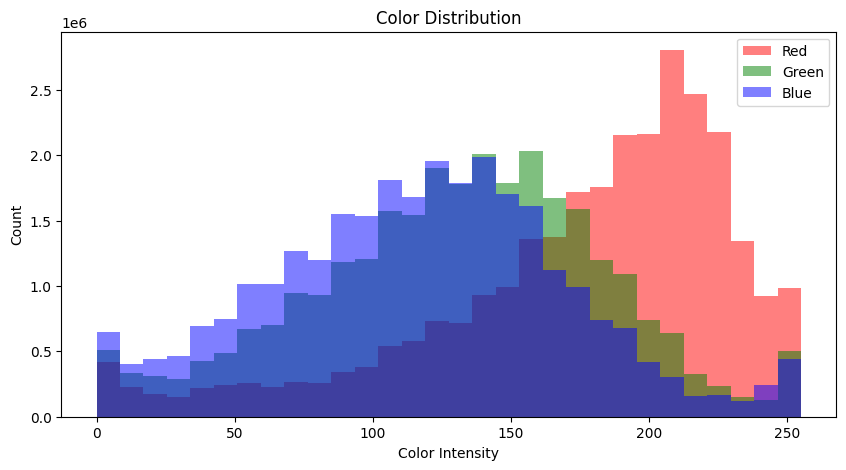

In [ ]:
plot_color_distribution(augumented_folder)

In [ ]:
def plot_blur_detection(root_dir):
    blur_values = []

    for class_name in os.listdir(root_dir):
        class_path = os.path.join(root_dir, class_name)
        if os.path.isdir(class_path):
            for file in os.listdir(class_path):
                img_path = os.path.join(class_path, file)
                try:
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    if img is not None:
                        blur_value = cv2.Laplacian(img, cv2.CV_64F).var()
                        blur_values.append(blur_value)
                except:
                    continue

    plt.figure(figsize=(10, 5))
    plt.hist(blur_values, bins=30, color='brown', alpha=0.7)
    plt.xlabel("Laplacian Variance")
    plt.ylabel("Count")
    plt.title("Blur Detection (Higher is Sharper)")
    plt.show()

## Image Explanation

The image generated by this code is a histogram showing the distribution of Laplacian variance values, which are used as an indicator of blurriness or sharpness in your dataset.

X-axis: Represents the Laplacian variance values. Higher values generally indicate sharper images, while lower values suggest blurrier images.
Y-axis: Represents the frequency or count of images with a particular Laplacian variance value.
Bars: Each bar in the histogram represents a range of Laplacian variance values, and the height of the bar indicates how many images fall within that range.

## Interpretation

Blurriness Distribution: The histogram provides an overview of the blurriness distribution in your dataset.
A peak towards the lower end of the x-axis suggests a higher number of blurry images.
A peak towards the higher end indicates more sharp images.
A wide distribution might indicate a mix of blurry and sharp images.
Image Quality: This information can be used to assess the overall image quality in your dataset. A large number of blurry images might require further investigation or preprocessing techniques to improve sharpness.
Data Filtering: You could potentially use the Laplacian variance to filter out excessively blurry images from your dataset if they are deemed unsuitable for your task.
In summary, this histogram provides insights into the sharpness and blurriness characteristics of your image dataset, which can be valuable for data analysis, preprocessing, and quality control

In [ ]:
plot_blur_detection(augumented_folder)

In [ ]:
def plot_aspect_ratio_distribution(root_dir):
    aspect_ratios = []
    for class_name in os.listdir(root_dir):
        class_path = os.path.join(root_dir, class_name)
        if os.path.isdir(class_path):
            for file in os.listdir(class_path):
                img_path = os.path.join(class_path, file)
                try:
                    with Image.open(img_path) as img:
                        aspect_ratios.append(img.size[0] / img.size[1])
                except:
                    continue

    plt.figure(figsize=(10, 5))
    plt.hist(aspect_ratios, bins=20, color='purple', alpha=0.7)
    plt.xlabel("Aspect Ratio (Width / Height)")
    plt.ylabel("Count")
    plt.title("Aspect Ratio Distribution")
    plt.show()

## Image Explanation

The image generated by this code is a histogram that shows the distribution of aspect ratios in your dataset.

X-axis: Represents the aspect ratio (width / height) of the images.
Y-axis: Represents the frequency or count of images with a particular aspect ratio.
Bars: Each bar in the histogram represents a range of aspect ratios, and the height of the bar indicates how many images fall within that range.

## Interpretation

Common Aspect Ratios: The tallest bars in the histogram indicate the most common aspect ratios in your dataset. For example, if the tallest bar is around 1.0, it means you have a lot of images that are roughly square (width and height are similar).
Variability: The spread of the histogram shows the variability of aspect ratios. A narrow histogram means most images have similar aspect ratios, while a wide histogram indicates more diversity in image shapes.
Outliers: Bars at the extreme ends of the histogram might represent images with unusual aspect ratios (very wide or very tall). These could be panoramic images or images with unusual cropping.

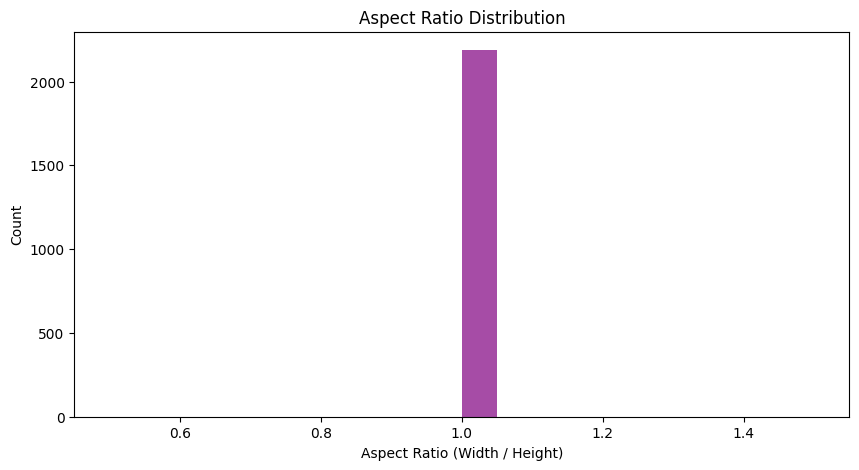

In [ ]:
plot_aspect_ratio_distribution(augumented_folder)

In [ ]:
def plot_augmentation_effect(original_root, augmented_root):
    orig_counts = {cls: len(os.listdir(os.path.join(original_root, cls))) for cls in os.listdir(original_root)}
    aug_counts = {cls: len(os.listdir(os.path.join(augmented_root, cls))) for cls in os.listdir(augmented_root)}

    labels = orig_counts.keys()
    orig_values = orig_counts.values()
    aug_values = [aug_counts[cls] for cls in labels]

    plt.figure(figsize=(10, 5))
    width = 0.4
    x = np.arange(len(labels))

    plt.bar(x - width/2, orig_values, width, label="Original", color='blue', alpha=0.6)
    plt.bar(x + width/2, aug_values, width, label="Augmented", color='red', alpha=0.6)

    plt.xticks(x, labels, rotation=45)
    plt.xlabel("Class Name")
    plt.ylabel("Number of Images")
    plt.title("Effect of Augmentation on Class Distribution")
    plt.legend()
    plt.show()

The plot_augmentation_effect function is designed to visually compare the number of images in each class before and after data augmentation. This helps you understand how augmentation has impacted the class distribution of your dataset.

## Image Explanation

The image generated by this code is a bar plot showing the effect of data augmentation on the class distribution of your dataset.

X-axis: Represents the different classes in your dataset.
Y-axis: Represents the number of images in each class.
Blue Bars: Show the original number of images in each class before augmentation.
Red Bars: Show the number of images in each class after augmentation.

## Interpretation

Increased Dataset Size: The red bars are generally much taller than the blue bars, indicating that data augmentation has significantly increased the number of images in most classes.
Class Distribution: Compare the heights of the blue and red bars for each class. If the red bars are proportionally taller across all classes, it means augmentation has maintained the relative distribution of classes. If some red bars are disproportionately taller than others, it suggests augmentation might have introduced some class imbalance.

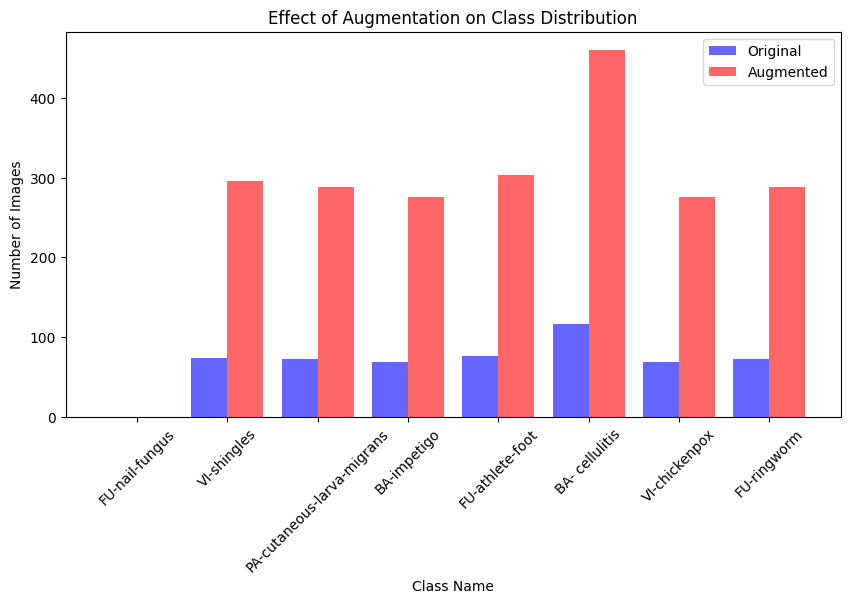

In [ ]:
plot_augmentation_effect(folder_path, augumented_folder)

In [ ]:
def load_images_and_labels(folder_path):
    """Loads images and labels using extracted labels from filenames."""
    labels_dict = extract_labels_from_filenames(folder_path)  # Use your function

    images = []
    labels = []

    # Create a label map (unique labels to numerical indices)
    label_map = {label: i for i, label in enumerate(set(labels_dict.values()))}

    for subdir in os.listdir(folder_path):
        subdir_path = os.path.join(folder_path, subdir)
        if os.path.isdir(subdir_path):
            for file in os.listdir(subdir_path):
                if file.lower().endswith((".jpg", ".jpeg", ".png")):
                    img_path = os.path.join(subdir_path, file)

                    try:
                        # Load image and resize
                        img = Image.open(img_path).convert("RGB")
                        img = img.resize((224, 224))
                        img = np.array(img) / 255.0

                        images.append(img)

                        # Get numerical label from label_map
                        label = labels_dict.get(file, subdir)
                        labels.append(label_map[label])

                    except Exception as e:
                        print(f"Error loading {img_path}: {e}")

    return np.array(images), np.array(labels), label_map # Return the label_map

In [ ]:
def build_cnn_model(input_shape=(224, 224, 3), num_classes=8):
    """Builds a CNN model for skin disease classification."""
    model = Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D(2, 2),
        layers.BatchNormalization(),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),
        layers.BatchNormalization(),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),
        layers.BatchNormalization(),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')  # Softmax for multi-class classification
    ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
def train_cnn_model(data_dir, epochs=10, batch_size=32):
    images, labels, label_map = load_images_and_labels(data_dir)

    labels = to_categorical(labels, num_classes=len(label_map))
    X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

    model = build_cnn_model(input_shape=(224, 224, 3), num_classes=len(label_map))
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val))

    return model, label_map

In [ ]:
model, label_map = train_cnn_model(augumented_folder, epochs=10, batch_size=32)

Epoch 1/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 243s 4s/step - accuracy: 0.2941 - loss: 16.9855 - val_accuracy: 0.1530 - val_loss: 4.5148
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 253s 4s/step - accuracy: 0.3884 - loss: 8.4209 - val_accuracy: 0.1416 - val_loss: 4.9867
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 257s 4s/step - accuracy: 0.3850 - loss: 3.7058 - val_accuracy: 0.1164 - val_loss: 6.9225
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 232s 4s/step - accuracy: 0.4162 - loss: 3.2544 - val_accuracy: 0.1324 - val_loss: 3.5158
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 264s 4s/step - accuracy: 0.4239 - loss: 2.6580 - val_accuracy: 0.1370 - val_loss: 9.9323
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 233s 4s/step - accuracy: 0.4456 - loss: 2.1434 - val_accuracy: 0.2260 - val_loss: 3.3867
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 254s 4s/step - accuracy: 0.4672 - loss: 1.6288 - val_accuracy: 0.2489 - val_loss: 2.4820
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 230s 4s/step - accuracy: 0.4868 - loss: 1.6541 - val_accuracy: 0.3196 - 

In [ ]:
def create_test_generator(test_dir, batch_size=32):
    """Creates a test data generator for evaluation."""
    test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)  # Normalize pixel values
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical',  # Match with training class mode
        shuffle=False
    )
    return test_generator

In [ ]:
def evaluate_model(model, test_generator, class_names):
    """Evaluates the trained CNN model on the test dataset."""
    y_true = test_generator.classes
    y_pred_prob = model.predict(test_generator)
    y_pred = np.argmax(y_pred_prob, axis=1)

    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

Found 2188 images belonging to 8 classes.
69/69 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step
Classification Report:
                            precision    recall  f1-score   support

            BA- cellulitis       0.29      0.15      0.20       460
               BA-impetigo       0.09      0.26      0.13       276
           FU-athlete-foot       0.02      0.03      0.02       304
            FU-nail-fungus       0.00      0.00      0.00         0
               FU-ringworm       0.02      0.01      0.01       288
PA-cutaneous-larva-migrans       0.01      0.01      0.01       288
             VI-chickenpox       0.04      0.01      0.02       276
               VI-shingles       0.00      0.00      0.00       296

                  accuracy                           0.07      2188
                 macro avg       0.06      0.06      0.05      2188
              weighted avg       0.08      0.07      0.07      2188



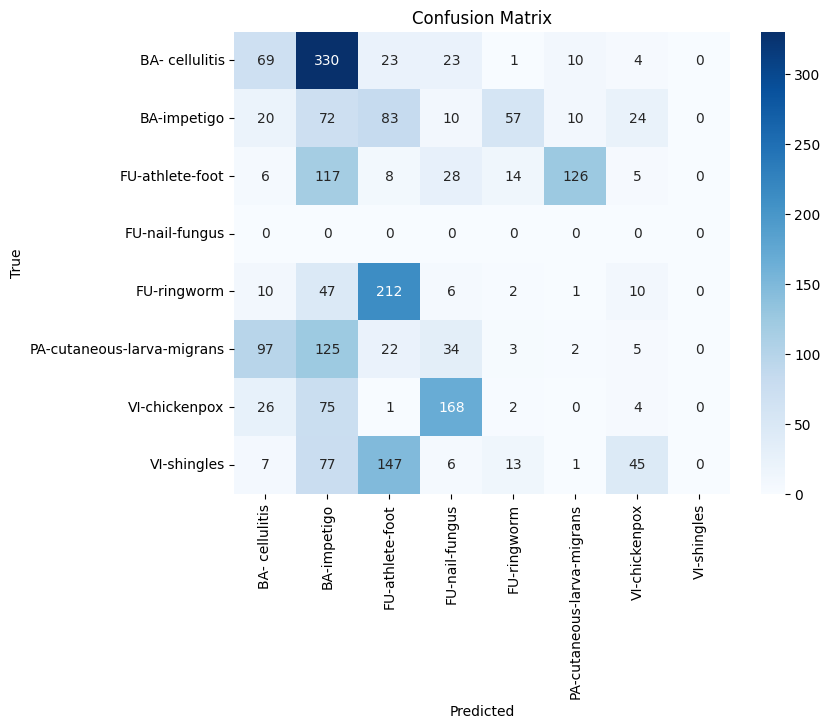

In [ ]:
# Load test data generator
test_generator = create_test_generator(augumented_folder)

# Get the actual class names from the test generator
class_names = list(test_generator.class_indices.keys())

# Evaluate the model
evaluate_model(model, test_generator, class_names)

In [ ]:
def save_trained_model(model, model_path="skin_disease_model.h5"):
    """Saves the trained CNN model to a file."""
    model.save(model_path)
    print(f"Model saved to {model_path}")

In [ ]:
model_path = "/content/drive/MyDrive/Skinn-data/Skin-disease-dataset/model"
save_trained_model(model, )

Model saved to skin_disease_model.h5


In [ ]:
def predict_image(img_path, model, class_names):
    """Predicts the class of a given image using the trained model."""
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    predicted_label = np.argmax(prediction)
    predicted_class = class_names[predicted_label]

    print(f"Predicted class: {predicted_class}")
    return predicted_class

In [ ]:
from tensorflow.keras.preprocessing import image

test_img = "/content/drive/MyDrive/Skin-disease_dataset/Cancius_dataset/skin-disease-datasaet/test_set/BA- cellulitis/BA- cellulitis (1).webp"
predicted_class = predict_image(test_img, model, list(label_map.keys()))
print(f"Predicted Skin Disease: {predicted_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
Predicted class: PA-cutaneous-larva-migrans
Predicted Skin Disease: PA-cutaneous-larva-migrans
